In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
INFERENCE_CSV_PATH = '../data/predictions/eca_nfnet_l0_Exp_noamp_64bs_5sec_BasicAug_SqrtBalancing_Radamlr1e3_CosBatchLR1e6_Epoch50_FocalBCELoss_LSF1005.csv'
assert os.path.exists(INFERENCE_CSV_PATH), f"File not found: {INFERENCE_CSV_PATH}"

TRAIN_CSV_PATH = '/workspace/birdsongs/data/xcm/train.csv'
assert os.path.exists(TRAIN_CSV_PATH), f"File not found: {TRAIN_CSV_PATH}"

BIRD2IDX_PATH = '../data/bird2int_xcm.json'
assert os.path.exists(BIRD2IDX_PATH), f"File not found: {BIRD2IDX_PATH}"

In [3]:
pred_df = pd.read_csv(INFERENCE_CSV_PATH)
train_df = pd.read_csv(TRAIN_CSV_PATH)

/tmp/ipykernel_366537/1816391703.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(TRAIN_CSV_PATH)


In [4]:
with open(BIRD2IDX_PATH, 'r') as f:
    bird2idx = json.load(f)
idx2bird = {v: k for k, v in bird2idx.items()}

In [5]:
pred_df.head()

,row_id,gretit1,eurbla,comcha,comchi1,eurrob1,sonthr1,blackc1,blutit,redcro,...,blhsal1,yefgra1,flrtan1,amecro,cedwax,yefcan,reblei,melthr,other,fold
0,XC546190_5,0.311164,0.428786,0.240839,0.057791,0.195965,0.365327,0.132511,0.706218,0.002978,...,0.000341,0.000548,0.000336,0.001301,0.001098,0.000737,0.000934,0.000529,0.209846,0
1,XC546190_10,0.193441,0.381622,0.331960,0.409418,0.117762,0.247215,0.166617,0.793945,0.006922,...,0.000548,0.000513,0.000449,0.000830,0.000255,0.000278,0.000621,0.000621,0.284922,0
2,XC546190_15,0.253255,0.502443,0.233812,0.070376,0.209073,0.205499,0.106992,0.763386,0.003734,...,0.000679,0.001044,0.000604,0.001453,0.000635,0.001919,0.001241,0.000793,0.256477,0
3,XC546190_20,0.186753,0.397777,0.369929,0.358527,0.187101,0.276664,0.235509,0.650918,0.008989,...,0.001372,0.001451,0.000616,0.001367,0.000786,0.001027,0.001613,0.000847,0.305764,0
4,XC546190_25,0.147077,0.569926,0.323981,0.287633,0.168433,0.160335,0.435689,0.644913,0.005387,...,0.001291,0.003018,0.000477,0.003507,0.000617,0.001039,0.001040,0.000860,0.320315,0


In [6]:
train_df['primary_bird'] = train_df['ebird_code'].apply(lambda x: idx2bird[x])

In [7]:
train_df['row_id'] = train_df['filepath'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

In [8]:
pred_df['file_id'] = pred_df['row_id'].apply(lambda x: x.split('_')[0])

In [9]:
merged_df = pred_df.merge(train_df, left_on='file_id', right_on='row_id', how='left')

In [10]:
merged_df['ebird_code_secondary'] = merged_df['ebird_code_secondary'].fillna('[]').apply(eval)

Quality: A
	Accuracy: 0.5260 (216129/410915)
	FN fraction (threshold = 10%): 0.1762
	Average Confidence: 0.4795
	Average Secondary Birds Confidence: 0.1750
	Average Number of Secondary Birds per Sample: 1.6447
	Average Non-labeled Birds Confidence: 0.0071



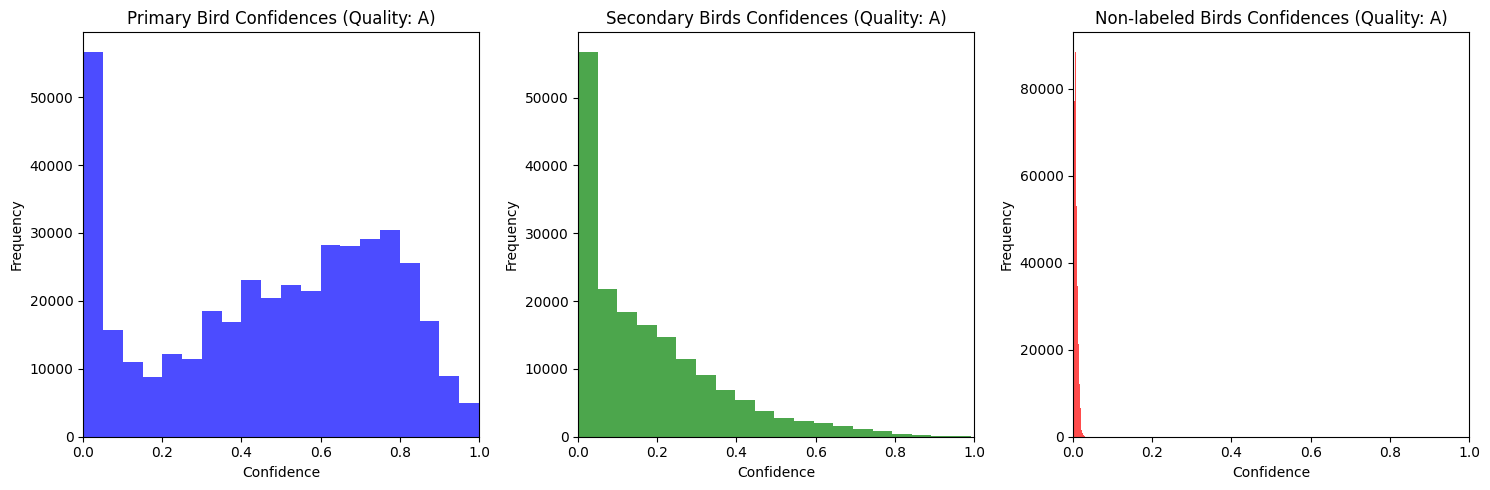


Quality: B
	Accuracy: 0.4928 (216616/439582)
	FN fraction (threshold = 10%): 0.2003
	Average Confidence: 0.4545
	Average Secondary Birds Confidence: 0.1763
	Average Number of Secondary Birds per Sample: 1.5657
	Average Non-labeled Birds Confidence: 0.0074



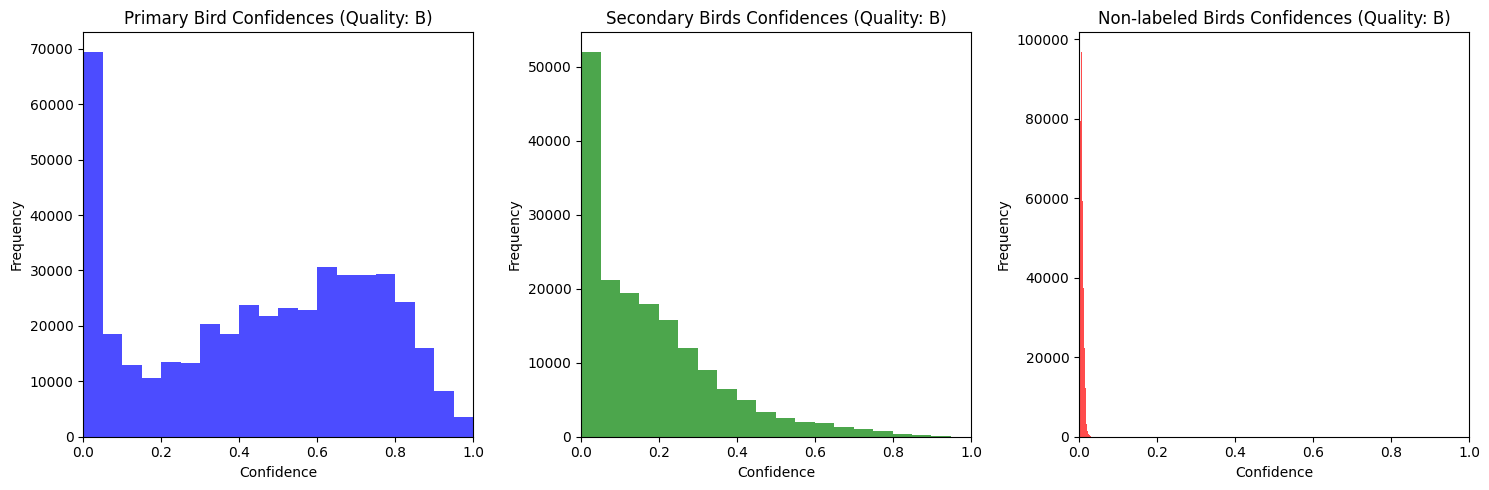


Quality: C
	Accuracy: 0.4555 (75219/165143)
	FN fraction (threshold = 10%): 0.2243
	Average Confidence: 0.4275
	Average Secondary Birds Confidence: 0.1717
	Average Number of Secondary Birds per Sample: 1.6081
	Average Non-labeled Birds Confidence: 0.0071



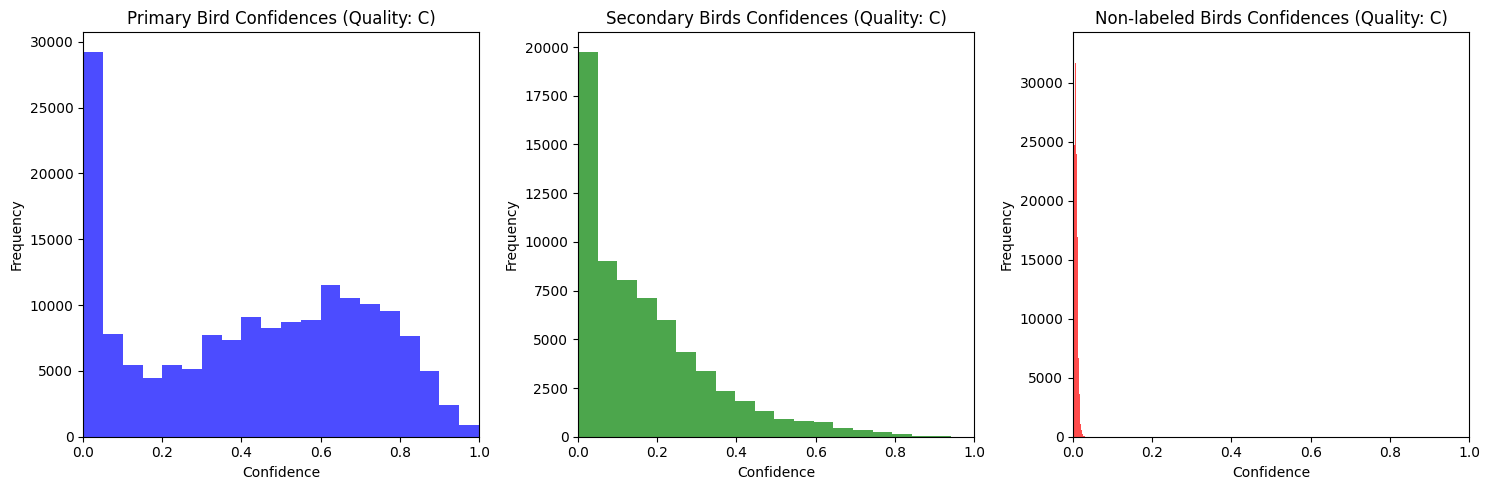

In [19]:
# Vectorized computation - avoid row-by-row apply operations
quality_groups = merged_df.groupby('quality')

# Pre-compute bird species columns once
metadata_cols = {'row_id', 'file_id', 'fold', 'filepath', 'start_time', 'end_time', 
                 'low_freq', 'high_freq', 'ebird_code', 'ebird_code_multilabel',
                 'ebird_code_secondary', 'call_type', 'sex', 'lat', 'long', 'length',
                 'microphone', 'license', 'source', 'local_time', 'detected_events',
                 'event_cluster', 'peaks', 'quality', 'recordist', 'genus',
                 'species_group', 'order', 'genus_multilabel', 'species_group_multilabel',
                 'order_multilabel', 'primary_bird', 'row_id_x', 'row_id_y'}
all_bird_species = set(bird2idx.keys())

for quality, group in quality_groups:
    bird_cols = [col for col in group.columns if col not in metadata_cols]
    
    # 1. Vectorized primary bird accuracy
    primary_birds = group['primary_bird'].values
    bird_col_to_idx = {bird: i for i, bird in enumerate(bird_cols)}
    primary_indices = [bird_col_to_idx[bird] for bird in primary_birds]
    
    bird_values = group[bird_cols].values  # Shape: (n_samples, n_birds)
    primary_confidences = bird_values[np.arange(len(primary_indices)), primary_indices]
    
    correct_preds = (primary_confidences >= 0.5).sum()
    incorrect_preds = (primary_confidences < 0.1).sum()
    total_preds = len(group)
    accuracy = correct_preds / total_preds if total_preds > 0 else 0
    
    print(f"Quality: {quality}")
    print(f"\tAccuracy: {accuracy:.4f} ({correct_preds}/{total_preds})")
    print(f"\tFN fraction (threshold = 10%): {incorrect_preds/total_preds:.4f}")
    print(f"\tAverage Confidence: {primary_confidences.mean():.4f}")
    
    # 2. Vectorized secondary bird processing
    secondary_birds_lists = group['ebird_code_secondary'].values
    secondary_masks = np.zeros((len(group), len(bird_cols)), dtype=bool)
    
    for idx, secondary_birds in enumerate(secondary_birds_lists):
        for bird in secondary_birds:
            if bird in bird_col_to_idx:
                secondary_masks[idx, bird_col_to_idx[bird]] = True
    
    # Compute average for samples with secondary birds
    secondary_has_birds = secondary_masks.any(axis=1)
    if secondary_has_birds.any():
        secondary_confidences_per_sample = np.where(
            secondary_has_birds,
            (bird_values * secondary_masks).sum(axis=1) / secondary_masks.sum(axis=1).clip(min=1),
            np.nan
        )
        valid_secondary = secondary_confidences_per_sample[secondary_has_birds]
        print(f"\tAverage Secondary Birds Confidence: {valid_secondary.mean():.4f}")
    else:
        secondary_confidences_per_sample = np.full(len(group), np.nan)
        print(f"\tAverage Secondary Birds Confidence: N/A")
    
    print(f"\tAverage Number of Secondary Birds per Sample: {np.mean([len(s) for s in secondary_birds_lists]):.4f}")
    
    # 3. FULLY VECTORIZED non-labeled bird processing (MAJOR SPEEDUP)
    # Create labeled mask: primary + secondary birds
    labeled_masks = np.zeros((len(group), len(bird_cols)), dtype=bool)
    for idx, primary_bird in enumerate(primary_birds):
        if primary_bird in bird_col_to_idx:
            labeled_masks[idx, bird_col_to_idx[primary_bird]] = True
    labeled_masks |= secondary_masks
    
    # Non-labeled mask is the inverse
    non_labeled_masks = ~labeled_masks
    
    # Compute average non-labeled confidence per sample
    non_labeled_counts = non_labeled_masks.sum(axis=1)
    non_labeled_confidences = np.where(
        non_labeled_counts > 0,
        (bird_values * non_labeled_masks).sum(axis=1) / non_labeled_counts,
        0
    )
    
    avg_non_labeled = non_labeled_confidences.mean()
    print(f"\tAverage Non-labeled Birds Confidence: {avg_non_labeled:.4f}\n")
    
    # 4. Plotting (no changes needed, but use pre-computed arrays)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].hist(primary_confidences, bins=20, color='blue', alpha=0.7)
    axes[0].set_title(f'Primary Bird Confidences (Quality: {quality})')
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Frequency')
    axes[0].set_xlim(0, 1)
    
    if secondary_has_birds.any():
        axes[1].hist(valid_secondary, bins=20, color='green', alpha=0.7)
    axes[1].set_title(f'Secondary Birds Confidences (Quality: {quality})')
    axes[1].set_xlabel('Confidence')
    axes[1].set_ylabel('Frequency')
    axes[1].set_xlim(0, 1)
    
    axes[2].hist(non_labeled_confidences, bins=20, color='red', alpha=0.7)
    axes[2].set_title(f'Non-labeled Birds Confidences (Quality: {quality})')
    axes[2].set_xlabel('Confidence')
    axes[2].set_ylabel('Frequency')
    axes[2].set_xlim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    print()